# Supervised Classification with Quantum-Enhanced Support Vector Machines

## Introduction
Classification algorithms and methods for machine learning are essential for pattern recognition and data mining applications. Well known techniques such as support vector machines and neural networks have blossomed over the last two decades as a result of the spectacular advances in classical hardware computational capabilities and speed. This progress in computer power made it possible to apply techniques, that were theoretically developed towards the middle of the 20th century, on classification problems that were becoming increasingly challenging.

A key concept in classification methods is that of a kernel. Data cannot typically be separated by a hyperplane in its original space. A common technique used to find such a hyperplane consists on applying a non-linear transformation function to the data. This function is called a feature map, as it transforms the raw features, or measurable properties, of the phenomenon or subject under study. Classifying in this new feature space -and, as a matter of fact, also in any other space, including the raw original one- is nothing more than seeing how close data points are to each other. This is the same as computing the inner product for each pair of data in the set. So, in fact we do not need to compute the non-linear feature map for each datum, but only the inner product of each pair of data points in the new feature space. This collection of inner products is called the kernel and it is perfectly possible to have feature maps that are hard to compute but whose kernels are not.

In this notebook we provide an example of a classification problem that requires a feature map for which computing the kernel is not efficient classically -this means that the required computational resources are expected to scale exponentially with the size of the problem. We show how this can be solved in a quantum processor by a direct estimation of the kernel in the feature space. The method we used falls in the category of what is called supervised learning, consisting of a training phase (where the kernel is calculated and the support vectors obtained) and a test or classification phase (where new unlabelled data is classified according to the solution found in the training phase).

References and additional details:

[1] Vojtech Havlicek, Antonio D. Córcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow, and Jay M. Gambetta1, "Supervised learning with quantum enhanced feature spaces," [arXiv: 1804.11326](https://arxiv.org/pdf/1804.11326.pdf)

## 1. Synthetic Dataset

In the first section, we prepare a synthetic dataset, which is used for training, testing and the final prediction.

You can easily switch to a different dataset, such as the Breast Cancer dataset, by replacing 'ad_hoc_data' to 'Breast_cancer' below.

### 1. (a) Construct Synthetic Dataset

In [1]:
from AI_qsvm_datasets import *
from qiskit_aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit_aqua.input import get_input_instance
from qiskit_aqua import run_algorithm

import logging
from qiskit_aqua._logging import set_logging_config, build_logging_config
set_logging_config(build_logging_config(logging.DEBUG))  # choose INFO, DEBUG to see the log

In [2]:
feature_dim = 2
sample_Total, training_input, test_input, class_labels = ad_hoc_data(
    training_size=20, test_size=10, n=feature_dim, gap=0.3, PLOT_DATA=False)

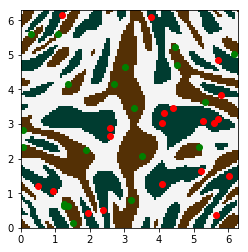

In [3]:
%matplotlib inline
plt.xlim(0, 2*np.pi)
plt.ylim(0, 2*np.pi)
plt.scatter(training_input['A'][:,0], training_input['A'][:,1], c='r')
plt.scatter(training_input['B'][:,0], training_input['B'][:,1], c='g')
plt.imshow(np.asmatrix(sample_Total).T, interpolation='nearest',
           cmap='BrBG', extent=[0, 2*np.pi, 2*np.pi, 0])

With the dataset ready we begin using Qiskit Aqua to train a quantum SVM.

### 1. (b) Select Feature Map and See Associated Circuit

In [4]:
# the feature map: IZ, ZI, ZZ
from qiskit_aqua.algorithms.components.feature_maps.second_order_expansion import SecondOrderExpansion
feature_map = SecondOrderExpansion()
feature_map.init_args(num_qubits=2, depth=2, entanglement='linear')

2018-11-12 14:53:04,591:qiskit_aqua.algorithms.components.feature_maps.pauli_expansion:INFO: Pauli terms include: ['ZI', 'IZ', 'ZZ']


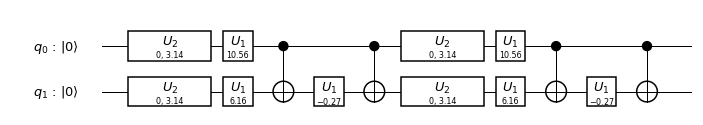

In [6]:
# see the actual circuits
datapoints, class_to_label = split_dataset_to_data_and_labels(training_input)
circuit = feature_map.construct_circuit(datapoints[0][0])
from qiskit.tools.visualization import *
circuit_drawer(circuit, output='mpl')

### 1. (c) Build SVM Algorithm

In [7]:
# the algorithm: QSVM_Kernel
from qiskit_aqua.algorithms.many_sample.qsvm.qsvm_kernel import QSVM_Kernel
from qiskit.backends.aer import QasmSimulator
simulator = QasmSimulator()
algorithm = QSVM_Kernel()
algorithm.setup_quantum_backend(backend=simulator)
algorithm.init_args(training_dataset=training_input,
                    test_dataset=None,
                    datapoints=None,
                    feature_map=feature_map)
algorithm.enable_circuit_summary()

2018-11-12 14:54:12,983:qiskit_aqua.quantumalgorithm:INFO: Qiskit Terra version 0.7.0
2018-11-12 14:54:12,985:qiskit_aqua.quantumalgorithm:INFO: Algorithm: 'QSVM.Kernel' setup with backend 'qasm_simulator', with following setting:
 {'shots': 1024, 'skip_transpiler': False, 'config': {'noise_params': None}, 'basis_gates': 'u0,u1,u2,u3,cx,cz,id,x,y,z,h,s,sdg,t,tdg,rzz,snapshot,wait,noise,save,load', 'coupling_map': 'all-to-all', 'initial_layout': None, 'max_credits': 10, 'seed': None, 'qobj_id': None, 'hpc': None}
{'timeout': None}


### 1. (d) Train SVM

In [8]:
# builds circuits, runs them to find the kernel matrix
# then solves quadratic programming to find the support vectors
datapoints, class_to_label = split_dataset_to_data_and_labels(training_input)
algorithm.train(data=datapoints[0], labels=datapoints[1])

2018-11-12 14:54:39,993:qiskit_aqua.utils.run_circuits:DEBUG: Submitting 780 circuits.
0-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
1-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
2-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
3-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
4-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
5-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
6-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
7-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
8-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
9-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
10-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
11-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
12-th circuit: 2 qubits, 2 classica

2018-11-12 14:54:40,997:qiskit_aqua.utils.qpsolver:DEBUG: Solving QP problem is completed.


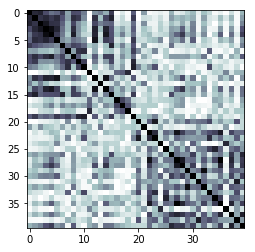

In [9]:
# block diagonal pattern because in the data A comes first, then B
# [[DARK, LIGHT], [LIGHT, DARK]] --> this means the kernel was good and could separate 
kernel_matrix = algorithm.ret['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest',
                 origin='upper', cmap='bone_r')
plt.show()

In [10]:
# support vectors
algorithm.ret['svm']

{'alphas': array([2.7299008 , 3.74954164, 2.26207294, 2.50423762, 1.32442235,
        4.17212636, 0.91258842, 4.3565115 , 2.92629769, 0.19526073]),
 'bias': array([-0.05014158]),
 'support_vectors': array([[0.9424778 , 1.0681415 ],
        [4.39822972, 3.45575192],
        [5.2150438 , 1.63362818],
        [5.65486678, 0.37699112],
        [2.57610598, 2.63893783],
        [4.46106157, 5.2150438 ],
        [1.88495559, 2.26194671],
        [1.38230077, 4.1469023 ],
        [6.1575216 , 5.02654825],
        [0.06283185, 2.82743339]]),
 'yin': array([-1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.])}

### 1. (e) Test and Determine Accuracy

In [11]:
# take Support Vector that were found, and then use those to classify the new test data
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
algorithm.disable_circuit_summary()
algorithm.test(data=datapoints[0], labels=datapoints[1])

2018-11-12 14:55:15,277:qiskit_aqua.algorithms.many_sample.qsvm.qsvm_kernel_binary:DEBUG: Classification success for this set is 100.00% 



1.0

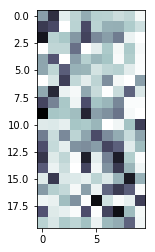

In [12]:
kernel_matrix_testing = algorithm.ret['kernel_matrix_testing']
img = plt.imshow(np.asmatrix(kernel_matrix_testing), interpolation='nearest',
                 origin='upper', cmap='bone_r')
plt.show()

In [13]:
algorithm.ret['testing_accuracy']

1.0

### [optional] Circuits for Finding Inner Products

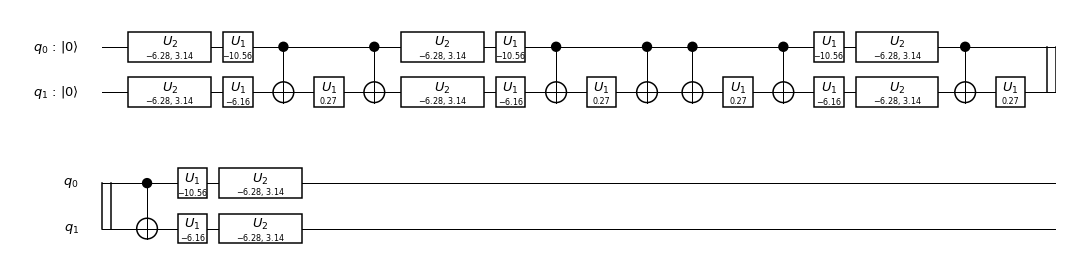

In [14]:
# concatenate with the inverse circuit to get expectation value
from qiskit import QuantumCircuit
inv_circuit = QuantumCircuit()
inv_circuit.data = [x.inverse() for x in reversed(circuit.data)]
circuit_drawer(circuit + inv_circuit, output='mpl')

### 2. The breast Cancer Dataset
Now we run our algorithm with the real-world dataset: the breast cancer dataset, we use the first two principal componenets as features.

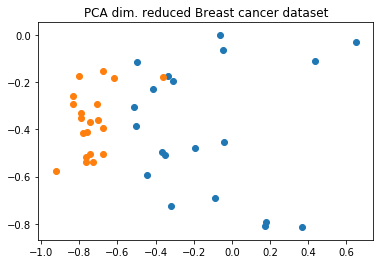

{'A': 0, 'B': 1} {0: 'A', 1: 'B'}


In [15]:
set_logging_config(build_logging_config(logging.DEBUG))  # choose INFO, DEBUG to see the log
feature_dim = 2
sample_Total, training_input, test_input, class_labels = Breast_cancer(
    training_size=20, test_size=10, n=feature_dim, PLOT_DATA=True)

datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
label_to_class = {label:class_name for class_name, label in class_to_label.items()}
print(class_to_label, label_to_class)

In [16]:
set_logging_config(build_logging_config(logging.INFO))  # choose INFO, DEBUG to see the log

params = {
    'problem': {'name': 'svm_classification', 'random_seed': 10598},
    'algorithm': {
        'name': 'QSVM.Kernel'
    },
    'backend': {'name': 'qasm_simulator', 'shots': 1024},
    'feature_map': {'name': 'SecondOrderExpansion', 'depth': 2, 'entanglement': 'linear'}
}

In [17]:
algo_input = get_input_instance('SVMInput')
algo_input.training_dataset  = training_input
algo_input.test_dataset = test_input
algo_input.datapoints = datapoints[0]
result = run_algorithm(params, algo_input)
print("testing success ratio: ", result['testing_accuracy'])
print("ground truth: {}".format(map_label_to_class_name(datapoints[1], label_to_class)))
print("predicted:    {}".format(result['predicted_classes']))

2018-11-12 14:55:55,700:qiskit_aqua.quantumalgorithm:INFO: Qiskit Terra version 0.7.0
2018-11-12 14:55:55,701:qiskit_aqua.quantumalgorithm:INFO: Algorithm: 'QSVM.Kernel' setup with backend 'qasm_simulator', with following setting:
 {'shots': 1024, 'skip_transpiler': False, 'config': {'noise_params': None}, 'basis_gates': 'u0,u1,u2,u3,cx,cz,id,x,y,z,h,s,sdg,t,tdg,rzz,snapshot,wait,noise,save,load', 'coupling_map': 'all-to-all', 'initial_layout': None, 'max_credits': 10, 'seed': 10598, 'qobj_id': None, 'hpc': None}
{'timeout': None}
2018-11-12 14:55:55,703:qiskit_aqua.algorithms.components.feature_maps.pauli_expansion:INFO: Pauli terms include: ['ZI', 'IZ', 'ZZ']


testing success ratio:  0.8
ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
predicted:    ['A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B']


kernel matrix during the training:


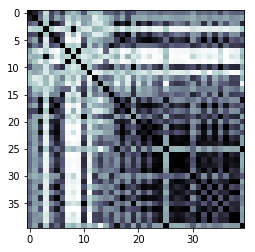

In [18]:
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()